<table><tr><td>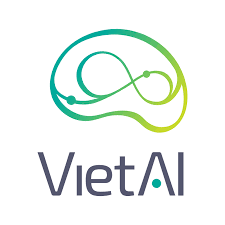</table></tr></td>

# Object Localization Exercise

@Class: Advanced Computer Vision

@Organization: VietAI

@Description: This exercise is to localize cat face in given images.

Student Infomation
- Name : [Nguyen Khoa Nguyen]
- Email  : [hangthieulong508@gmail.com]
- Phone : [0385127504]

## Mounting to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Check Colab GPU Information

In [ ]:
!nvidia-smi

Wed Sep 23 08:25:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading dataset

The original dataset can be found here. In the scope of this exercise, we use its cleaned version. The dataset contains:
* train.csv : .csv file of $8996$ rows, containing image names and coordinates of cat faces in format (x0, y0, width, height)
* test.csv : .csv file of $1000$ rows, containing image names
* images/ : a folder contains $9996$ images with size of $256 \times 256$

In [ ]:
import os
import random

import cv2

import numpy as np
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

In [ ]:
TRAIN_FILE = "/content/drive/My Drive/cat_face_exercise/train.csv"
TEST_FILE = "/content/drive/My Drive/cat_face_exercise/test.csv"
IMAGE_DIR = "/content/drive/My Drive/cat_face_exercise/images"

In [ ]:
df = pd.read_csv(TRAIN_FILE)
df.head()

,ImageId,y0,x0,height,width
0,04106.jpg,9,92,159,110
1,03683.jpg,16,52,184,165
2,04598.jpg,12,86,97,63
3,06239.jpg,49,53,92,149
4,01965.jpg,10,65,170,122


In [ ]:
test_df = pd.read_csv(TEST_FILE)
test_df.head()

,ImageId
0,03227.jpg
1,02572.jpg
2,05307.jpg
3,09114.jpg
4,07639.jpg


In [ ]:
train_df, val_df = train_test_split(df)

In [ ]:
print(len(df))
print(len(train_df))
print(len(val_df))
print(len(test_df))

8996
6747
2249
1000


In [ ]:
class Config:
    
    seed = 2020
    
    img_width = 256
    img_height = 256
    
    num_classes = 4

    batch_size = 32
    epochs = 2    
    lr = 1e-5
    
    verbose = 1
    
    best_checkpoint_path = 'best.h5'
    latest_checkpoint_path = 'latest.h5'
    
config = Config()   

## TODO 1: Data Loader
 You need to do the augmentation when loading data

In [ ]:
class ImageGenerator:
    
    def create(image_df, augument=True, is_train=True):
        while True:
            
            if is_train:
                image_df = shuffle(image_df, random_state=config.seed)
                
            for start in range(0, len(image_df), config.batch_size):
                end = min(start + config.batch_size, len(image_df))
                batch_images = []
                X_train_batch = image_df.iloc[start:end]
                
                if is_train:
                    batch_labels = np.zeros((len(X_train_batch), 4))
                
                for i in range(len(X_train_batch)):
                    # load image
                    image_path = os.path.join(IMAGE_DIR, X_train_batch.iloc[i]['ImageId'])
                    image = cv2.imread(image_path)
                    
                    if is_train:
                        x0 = X_train_batch.iloc[i]['x0']
                        y0 = X_train_batch.iloc[i]['y0']
                        w = X_train_batch.iloc[i]['width']
                        h = X_train_batch.iloc[i]['height']
                    
                        # augment data
                        if augument:
                            # TODO 1: augmentation
                            pass

                        batch_labels[i][0] = y0 / 256
                        batch_labels[i][1] = x0 / 256
                        batch_labels[i][2] = h / 256
                        batch_labels[i][3] = w / 256

                    batch_images.append(image / 255)
                    
                if is_train:
                    yield np.array(batch_images, np.float32), batch_labels
                else:
                    yield np.array(batch_images, np.float32)

In [ ]:
train_generator = ImageGenerator.create(
    train_df,
    augument=True
)

val_generator = ImageGenerator.create(
    val_df,
    augument=False
)

## TODO 2: Build your own model

In [ ]:
base_model = tf.keras.applications.DenseNet121(include_top=False,weights="imagenet",input_shape=(224,224,3))
base_model.trainable = False
model = tf.keras.Sequential([base_model,tf.keras.layers.GlobalAveragePooling2D(),tf.keras.layers.Dense(4,activation='softmax')])

# Print out model summary
model.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 4100      
Total params: 7,041,604
Trainable params: 4,100
Non-trainable params: 7,037,504
_________________________________________________________________


In [ ]:
model.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(lr=config.lr)
)

In [ ]:
best_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    config.best_checkpoint_path, 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='min'
    
)

latest_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    config.latest_checkpoint_path, 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=False, 
    save_weights_only=False,
    mode='min'
    
)

early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    mode="min", 
    patience=10
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    patience=2,
    factor=0.2,
    verbose=1,
    min_lr=1e-9
)

callbacks_list = [
    best_checkpoint,
    latest_checkpoint,
    reduce_lr,
    early
]

## Training

In [ ]:
model.fit_generator(
    train_generator,
    steps_per_epoch= np.ceil(float(len(train_df)) / config.batch_size),
    validation_data=val_generator,
    validation_steps= np.ceil(float(len(val_df)) / config.batch_size),
    epochs=config.epochs,
    callbacks=callbacks_list,
    verbose=config.verbose
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
211/211 [==============================] - ETA: 0s - loss: 0.0475
Epoch 00001: val_loss improved from inf to 0.04410, saving model to best.h5

Epoch 00001: saving model to latest.h5
211/211 [==============================] - 2053s 10s/step - loss: 0.0475 - val_loss: 0.0441
Epoch 2/2
211/211 [==============================] - ETA: 0s - loss: 0.0412
Epoch 00002: val_loss improved from 0.04410 to 0.04115, saving model to best.h5

Epoch 00002: saving model to latest.h5
211/211 [==============================] - 44s 208ms/step - loss: 0.0412 - val_loss: 0.0412


## Prediction

In [ ]:
test_generator = ImageGenerator.create(
    test_df,
    augument=False,
    is_train=False
)

In [ ]:
ls

best.h5  drive/  latest.h5  sample_data/


In [ ]:
pred_model = tf.keras.models.load_model(config.best_checkpoint_path)

In [ ]:
predict = pred_model.predict(test_generator,
                             steps=np.ceil(float(len(test_df)) / config.batch_size),
                             verbose=config.verbose)

32/32 [==============================] - 4s 125ms/step


In [ ]:
predict

array([[0.12995818, 0.09545399, 0.19684915, 0.5777387 ],
       [0.03270946, 0.52068204, 0.24098486, 0.20562361],
       [0.04230936, 0.35196802, 0.41374207, 0.19198057],
       ...,
       [0.12388864, 0.24146292, 0.30622572, 0.3284227 ],
       [0.11234836, 0.11472423, 0.23265646, 0.540271  ],
       [0.0711743 , 0.33499756, 0.3462507 , 0.24757741]], dtype=float32)

In [ ]:
predict = predict*256
predict = predict.astype(int)

In [ ]:
print(predict)

[[ 33  24  50 147]
 [  8 133  61  52]
 [ 10  90 105  49]
 ...
 [ 31  61  78  84]
 [ 28  29  59 138]
 [ 18  85  88  63]]


## Create submission file

In [ ]:
def clip(val, minval, maxval):
    """Clips a value between min and max (both including)."""
    if val < minval:
        return minval
    elif val > maxval:
        return maxval
    else:
        return val

In [ ]:
# clip coordinates to be inside image
for box in predict:
    y0, x0, height, width = box
    
    y1 = y0 + height
    x1 = x0 + width
    
    x0 = clip(x0, 0, 255)
    x1 = clip(x1, 0, 255)
    y0 = clip(y0, 0, 255)
    y1 = clip(y1, 0, 255)
    
    if y0 > y1:
        y0, y1 = y1, y0
    if x0 > x1:
        x0, x1 = x1, x0

    height = y1 - y0
    width = x1 - x0
    
    box[0] = y0
    box[1] = x0
    box[2] = height
    box[3] = width

In [ ]:
predict

array([[ 33,  24,  50, 147],
       [  8, 133,  61,  52],
       [ 10,  90, 105,  49],
       ...,
       [ 31,  61,  78,  84],
       [ 28,  29,  59, 138],
       [ 18,  85,  88,  63]])

In [ ]:
submissions = pd.DataFrame()
submissions["ImageId"] = test_df["ImageId"]
submissions["y0"] = predict[:, 0]
submissions["x0"] = predict[:, 1]
submissions["height"] = predict[:, 2]
submissions["width"] = predict[:, 3]
submissions.head()

,ImageId,y0,x0,height,width
0,03227.jpg,33,24,50,147
1,02572.jpg,8,133,61,52
2,05307.jpg,10,90,105,49
3,09114.jpg,21,44,98,92
4,07639.jpg,121,49,67,17


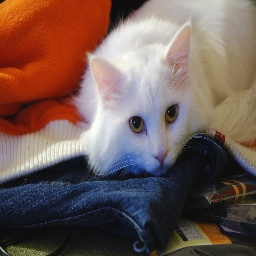

24 33 232 180 74


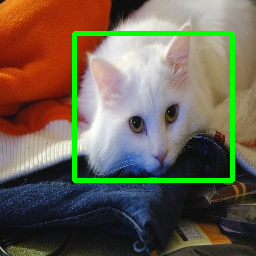

In [ ]:
image_path = "/content/drive/My Drive/cat_face_exercise/images"
image_name = "03227.jpg"
image = cv2.imread(image_path + "/" + image_name)
cv2_imshow(image)		
img = image.copy()
y0,x0,h,w =  33,	24,	50,	147
x1 = 256 - x0
x2 = x0 + h
y1 = y0 + w
print(x0,y0,x1,y1,x2)
cv2.rectangle(img,(x1 ,y0),(x2,y1),(0,255,0),4)
cv2_imshow(img)

[[ 11  53  54 136]]


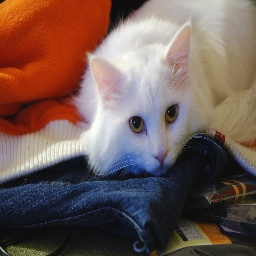

53 11 203 147 107


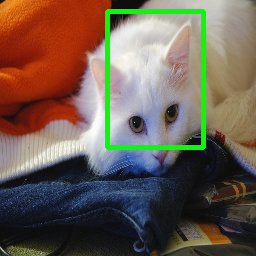

In [ ]:
image_path = "/content/drive/My Drive/cat_face_exercise/images/03227.jpg"
model = tf.keras.models.load_model("best.h5")
model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(lr=config.lr))
image = cv2.imread(image_path)
img = cv2.resize(image,(224,224))
img = img / 256
img = np.reshape(img,[1,224,224,3])
predict = model.predict(img)
predict = predict*256
predict = predict.astype(int)
print(predict)
for box in predict:
  y0, x0, height, width = box
  y1 = y0 + height
  x1 = x0 + width
  x0 = clip(x0, 0, 255)
  x1 = clip(x1, 0, 255)
  y0 = clip(y0, 0, 255)
  y1 = clip(y1, 0, 255)
        
  if y0 > y1:
    y0, y1 = y1, y0
  if x0 > x1:
    x0, x1 = x1, x0

  height = y1 - y0
  width = x1 - x0
        
  box[0] = y0
  box[1] = x0
  box[2] = height
  box[3] = width
      
    
cv2_imshow(image)		
image_show = image.copy()
x1 = 256 - x0
x2 = x0 + height
y1 = y0 + width
print(x0,y0,x1,y1,x2)
cv2.rectangle(image_show,(x1,y0),(x2,y1),(0,255,0),4)
cv2_imshow(image_show)

In [ ]:
submissions.to_csv("submission.csv", index=False)

In [ ]:
from google.colab.patches import cv2_imshow

## TODO 3: Visualize prediction

You need to visualize predicted bounding box on given test images

In [ ]:
N = len(test_df)
N

1000

In [ ]:
def draw_box(model, image_path):
    
    model = tf.keras.models.load_model(model)
    model.compile(loss='mean_squared_error',
        optimizer=tf.keras.optimizers.Adam(lr=config.lr)
    )
    image = cv2.imread(image_path)
    img = cv2.resize(image,(224,224))
    img = img / 256
    img = np.reshape(img,[1,224,224,3])
    predict = model.predict(img)
    predict = predict*256
    predict = predict.astype(int)
    print(predict)
    for box in predict:
      y0, x0, height, width = box
      
      y1 = y0 + height
      x1 = x0 + width
      
      x0 = clip(x0, 0, 255)
      x1 = clip(x1, 0, 255)
      y0 = clip(y0, 0, 255)
      y1 = clip(y1, 0, 255)
      
      if y0 > y1:
          y0, y1 = y1, y0
      if x0 > x1:
          x0, x1 = x1, x0

      height = y1 - y0
      width = x1 - x0
      
      box[0] = y0
      box[1] = x0
      box[2] = height
      box[3] = width
    
    
    cv2_imshow(image)		
    image_show = image.copy()
    
    x1 = 256 - x0
    x2 = x0 + height
    y1 = y0 + width
    print(x0,y0,x1,y1,x2)
    cv2.rectangle(image_show,(x1,y0),(x2,y1),(0,255,0),4)
    cv2_imshow(image_show)
    return
    

[[ 11  53  54 136]]


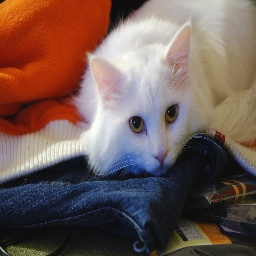

53 11 203 147 107


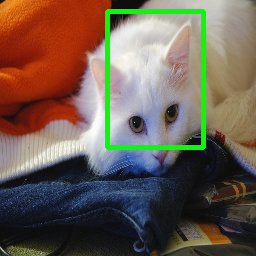

In [ ]:
draw_box(config.best_checkpoint_path,"/content/drive/My Drive/cat_face_exercise/images/03227.jpg")

In [ ]:
num_sample = 10

for idx in range(num_sample):
    idx = random.randint(0, N - 1)
    image_name = test_df["ImageId"].iloc[idx]
    image_path = os.path.join(IMAGE_DIR, image_name)
    
    draw_box(pred_model, image_path)

## TODO 4: Customize your model

You need to build a model that can check if cat face exists in given images. If exists, then predict the cat face coordinates

In [ ]:
# TODO 4:
check_model = tf.keras.applications.DenseNet121(include_top=False,weights="imagenet",input_shape=(224,224,3))
check_model.trainable = True
model = tf.keras.Sequential([base_model,tf.keras.layers.GlobalAveragePooling2D(),tf.keras.layers.Dense(4,activation='soigmid')])

# Print out model summary
model.summary()

base_model = tf.keras.applications.DenseNet121(include_top=False,weights="imagenet",input_shape=(224,224,3))
base_model.trainable = False
model = tf.keras.Sequential([base_model,tf.keras.layers.GlobalAveragePooling2D(),tf.keras.layers.Dense(4,activation='softmax')])

# Print out model summary
model.summary()

# What to submit?

Please send a .zip file to my email: thanglecao0412@gmail.com with the subject [VietAI Detection Exercise - Your name]. 
The .zip file includes
- This notebook when you finish
- Your submission file (.csv) on test dataset. Note that the submission file has the same format as **train.csv**
- Your best model checkpoint